
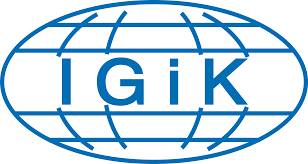


# FPCUP: Development of downstream applications supporting Sectoral Information system under Copernicus Climate Change Service

### Katarzyna Goch, Marcin Kluczek 

#### Institute of Geodesy and Cartography. Warsaw

##### Uncomment the following line to install [geemap](https://geemap.org) if needed. Add if statement for installing geemap on the client-side if not installed yet

In [ ]:
# !pip install geemap

### Import libraries

In [ ]:
import ee
import geemap
import geojson

### Load the map

In [ ]:
Map = geemap.Map()
Map

### Define periods for Sentinel-1 and Sentinel-2 data

In [ ]:
def getS1period(year):
    return [''.join([str(year),'-05-01']),''.join([str(year),'-08-31'])]

def getS2periods(year):
    return [[''.join([str(year),'-05-01']),''.join([str(year),'-05-30'])],
            [''.join([str(year),'-07-01']),''.join([str(year),'-07-31'])],
            [''.join([str(year),'-10-01']),''.join([str(year),'-10-31'])]]

### Select first and last year of analysis

In [ ]:
startYear = 2015
endYear = 2020

### Create GEOJSON object that will define AOI (here: example for Karczew area)

In [ ]:
aoi_geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              21.22180938720703,
              52.06526157080301
            ],
            [
              21.28129005432129,
              52.06526157080301
            ],
            [
              21.28129005432129,
              52.086310073072184
            ],
            [
              21.22180938720703,
              52.086310073072184
            ],
            [
              21.22180938720703,
              52.06526157080301
            ]
          ]
        ]
      }
    }
  ]
}

# Create GEE geometry AOI object
coords = aoi_geojson['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

# Centre the map
Map.centerObject(aoi)

### Load polygons with NUTS2 regions, Open GeoJSON with NUTS2 boundaries (1:3 Million) 
#### source: https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts

In [ ]:
with open('NUTS_RG_03M_2021_4326_LEVL_2.geojson', encoding='UTF-8') as f:
    gj = geojson.load(f)
# From the GeoJSON collection, create a FeatureCollection object
NUTS2 = ee.FeatureCollection(gj)
# Add as a layer to the map
Map.addLayer(NUTS2,{},'NUTS2')

#### Explanatory note
The data model is fitted to [Corine Land Cover 2018 (CLC2018) dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m), referring to land cover / land use status of year 2018. CLC2018 is one of the datasets produced within the frame the [Corine Land Cover programme](https://land.copernicus.eu/pan-european/corine-land-cover)

The classification algorithm is using radar and optical observations: 
- for radar data, C-band Synthetic Aperture Radar Ground Range Detected ([Sentinel-1 SAR GRD](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD?hl=en)) observations for period May-August 2018 were used
- for optical data, MultiSpectral Instrument, Level-2A ([Sentinel-2](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)) observations for May-October 2018 were used.

### Add Sentinel-2 observations for June 2018 <== they should be taken from 2017-2018 to match CLC2018 temporal resolution

In [ ]:
S2_trainingPeriods = getS2periods(2018)

### Define functions

In [ ]:
# Function to mask clouds using the Sentinel-2 QA band
# @param {ee.Image} image Sentinel-2 image
# @return {ee.Image} cloud masked Sentinel-2 image
def maskS2clouds(image):
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;

  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0) and (qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000)

# Function to add Sentinel-2 MSI: MultiSpectral Instrument, Level-2A data for 2018 for 10m resolution bands,
# pre-filtered with .filter() to get less cloudy granules
# @param {string} startDate starting date of the image collection acquisition in format 'yyy-mm-dd'
# @param {string} endDate ending date of the image collection acquisition in format 'yyy-mm-dd'
# @return {ee.ImageCollection} cloud masked Sentinel-2 images
def getS2dataset10m(period):
    S2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate(period[0],period[1]) \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                .map(maskS2clouds) \
                .select(['B4','B3','B2','B8'])
    return S2_collection

# Function to add Sentinel-2 MSI: MultiSpectral Instrument, Level-2A data for 2018 for 20m resolution bands,
# pre-filtered with .filter() to get less cloudy granules
# @param {string} startDate starting date of the image collection acquisition in format 'yyy-mm-dd'
# @param {string} endDate ending date of the image collection acquisition in format 'yyy-mm-dd'
# @return {ee.ImageCollection} cloud masked Sentinel-2 images
def getS2dataset20m(period):
    S2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterDate(period[0],period[1]) \
                .filterBounds(aoi) \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)) \
                .map(maskS2clouds) \
                .select(['B5','B6','B7','B8A'])
    return S2_collection

# Function to sort the least cloudy image
# @param {ee.Image} image Sentinel-2 image
# @return {ee.Image} least cloudy image sorted by 'CLOUD_COVER' attribute
def getImageLeastClouds(img):
    return ee.Image(img.sort('CLOUD_COVER').first())

def getS2image(period, reproject=False, crs=None):
    # Get the image collection for a selected period
    if reproject is True:
        imgCollection = getS2dataset20m(period)
    else:
        imgCollection = getS2dataset10m(period)
    # Sort the least cloudy image
    image = getImageLeastClouds(imgCollection)
    # Reproject if needed
    if reproject is True:
        the_image = image.reproject(crs = crs, scale=10.0)
    else:
        the_image = image
        
    return the_image

def getS2_bandNames():
    S2bands10m = [
        'S2_p1_B4','S2_p1_B3','S2_p1_B2','S2_p1_B8',
        'S2_p2_B4','S2_p2_B3','S2_p2_B2','S2_p2_B8',
        'S2_p3_B4','S2_p3_B3','S2_p3_B2','S2_p3_B8']
    S2bands20_to_10m = [
        'S2_p1_B5','S2_p1_B6','S2_p1_B7','S2_p1_B8A',
        'S2_p2_B5','S2_p2_B6','S2_p2_B7','S2_p2_B8A',
        'S2_p3_B5','S2_p3_B6','S2_p3_B7','S2_p3_B8A']
    
    return S2bands10m, S2bands20_to_10m

# Function to get a Sentinel-2 image composite in 10 m resolution for a specified period
# @param {list} S2_trainingPeriods liist of list containing start date and end date of analysis in format ['YYYY-MM-DD','YYYY-MM-DD']
# @return {ee.Image} a composite S2 image reprojected to 10.0 m resolution
def createS2compositeImage(S2_trainingPeriods):
    # Get the least cloudy image from bands with 10m resolution for months April, July and October
    S2_image_p1_10m = getS2image(S2_trainingPeriods[0], reproject=False) # problem
    S2_image_p2_10m = getS2image(S2_trainingPeriods[1], reproject=False)
    S2_image_p3_10m = getS2image(S2_trainingPeriods[2], reproject=False)

    # Get the least cloudy image from bands with 20m resolution for months April, July and October and reproject to 10m
    S2_image_p1_20_to_10m = getS2image(S2_trainingPeriods[0], reproject=True, crs=crs)
    S2_image_p2_20_to_10m = getS2image(S2_trainingPeriods[1], reproject=True, crs=crs)
    S2_image_p3_20_to_10m = getS2image(S2_trainingPeriods[2], reproject=True, crs=crs)

    # Get the names of the bands per native resolution
    S2bands10m, S2bands20_to_10m = getS2_bandNames()
    # Stack the images as bands in one image collection
    S2_image_reprojected = ee.ImageCollection([S2_image_p1_10m,
                                  S2_image_p2_10m,
                                  S2_image_p3_10m,
                                  S2_image_p1_20_to_10m,
                                  S2_image_p2_20_to_10m,
                                  S2_image_p3_20_to_10m]) \
                    .toBands() \
                    .rename(S2bands10m+S2bands20_to_10m) \
                    .clip(aoi)
    return S2_image_reprojected

### Sentinel-2 
- Get the common projection for further analysis from 10m band of Sentinel-2 image
- Get Sentinel-2 data for training.

In [ ]:
proj = getS2dataset10m(S2_trainingPeriods[0]).select('B4').first().projection().getInfo()
crs = proj['crs']

S2_image_reprojected = createS2compositeImage(S2_trainingPeriods)

### Add S2 RGB for June to visually compare the classification results

In [ ]:
S2_image06_10m = getS2image(['2018-06-01','2018-06-30'], reproject=False)
S2_RGB = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}
Map.addLayer(S2_image06_10m,S2_RGB,'S2 June 2018',False)

### Add Sentinel-1 observations
They should be taken from 2017-2018 to match CLC2018 temporal resolution

In [ ]:
# Select the period
S1_training_period = getS1period(2018)

# Function to add Sentinel-2 MSI: MultiSpectral Instrument, Level-2A data for 2018 for 10m resolution bands,
# pre-filtered with .filter() to get less cloudy granules
# @param {string} startDate starting date of the image collection acquisition in format 'yyy-mm-dd'
# @param {string} endDate ending date of the image collection acquisition in format 'yyy-mm-dd'
# @return {ee.ImageCollection} cloud masked Sentinel-2 images
def getS1dataset(period):
    S1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                .filterBounds(aoi) \
                .filterDate(period[0], period[1]) \
                .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    return S1_collection

# Function to get the median value of pixels
# @param {ee.FeatureCollection} collection of Sentinel-1 images
# @return {ee.Image} median value of pixels in the image collection
def getMedian(featurecollection):
    return featurecollection.median().clip(aoi)

# Function to create a composite combining the three polarisation modes (VV, VH, and VV-VH)
# @param {ee.Image} S1_image a Sentinel-1 images
# @return {ee.Image} a composite S1 image with each polarisation mode stacked as a band

# "A three-band composite image, combining the three polarisation modes (VV, VH, and VV-VH), 
# has been reported optimal for land cover characterisation" (Abdikan et al., 2014)
def getS1compositeImage(S1_image):
    return ee.ImageCollection([S1_image.select('VV'),
                               S1_image.select('VH'),
                               S1_image.select('VV').subtract(S1_image.select('VH'))]) \
                .toBands() \
                .rename(['VV','VH','VV-VH'])

# Function to reproject an image to S2 resolution
# @param {ee.Image} image an image
# @return {ee.Image} an image reprojected to S1 image CRS and 10.0 m resolution
def reproject_to_S2crs(image):
    return image.reproject(crs = crs, scale=10.0)

# Function to get a Sentinel-1 image composite in S2 resolution for specified period
# @param {list} period_S1 start date and end date of analysis in format ['YYYY-MM-DD','YYYY-MM-DD']
# @return {ee.Image} a composite S1 image reprojected to S2 image CRS and 10.0 m resolution
def createS1compositeImage(period_S1):
    # Sentinel-1 ground range detected images converted to decibels
    S1GRD_dataset = getS1dataset(period_S1)
    # Get the median value of pixels in the S1 collection
    S1db_image = getMedian(S1GRD_dataset)
    # Make composite image (VV,VH,VV-VH)
    S1composite_image = getS1compositeImage(S1db_image)
    # Reproject the composite to adjust to S2 CRS
    return reproject_to_S2crs(S1composite_image)

### Get Sentinel-1 data for training. 

In [ ]:
S1composite_image_reprojected = createS1compositeImage(S1_training_period)

### Create a composite from S1 composite and S2 images


In [ ]:
def getS1S2composite(S1image, S2image):
    # Get the names of the bands per native resolution
    S2bands10m, S2bands20_to_10m = getS2_bandNames()
    
    return ee.ImageCollection([S1image,S2image]) \
                .toBands() \
                .rename(['S1_VV','S1_VH','S1_VV-VH'] + S2bands10m + S2bands20_to_10m)

### S-1 and S-2 stacked composite

In [ ]:
S12_image = getS1S2composite(S1composite_image_reprojected, S2_image_reprojected)

### Load CLC for year 2018, which will be used as a reference data for training (Temporal extent: 2017-2018)

In [ ]:
clc2018 = ee.Image("COPERNICUS/CORINE/V20/100m/2018").clip(aoi)

### Define reclassified CLC class table

In [ ]:
CLC_class_table = """
Value	Color	Description
0	E6004D	Urban fabric
1	FFA6FF	Green urban areas
2	FFFFA8	Agricultural areas
3	80FF00	Forest and semi natural areas
4	A6A6FF	Wetlands
5	00CCF2	Water bodies
"""

legend_dict = geemap.legend_from_ee(CLC_class_table)
clc_recl_values = [ int(x[0]) for x in list(legend_dict.keys()) ]
clc_recl_names = [ x[2:] for x in list(legend_dict.keys()) ]
clc_recl_colors = [ legend_dict[x] for x in list(legend_dict.keys()) ]

### Remap CLC values to simpler classification 
Source: https://gis.stackexchange.com/questions/317305/remap-with-number-limits-and-not-individual-values-in-gee

In [ ]:
# Function to reclassify values defined by a range of values 
# @param {ee.Image}: image CLC image
# @param {number}: lowerLimit values higher or equal to this limit will be masked with new value
# @param {number}: upperLimit values lower or equal to this limit will be masked with new value
# @param {number}: newValue a new value masking the values within the specified range
# @return {ee.Image}: image a reclassified CLC image
def reclassifyCLC(image, lowerLimit, upperLimit, newValue):
    mask = image.gte(lowerLimit).And(image.lte(upperLimit))
    masked_image = image.where(mask, newValue)
    return masked_image

# Get the unique values from a CLC image
def getUniqueValues(image):
    imagedict = image.reduceRegion(reducer=ee.Reducer.toList())
    return list(set(imagedict.getInfo()['landcover']))

### Aggregate CLC classes to get clear division into natural, urban, forest/grasslands and agricultural areas

In [ ]:
clc2018recl = reclassifyCLC(clc2018, 100, 133, 0)    # urban (111)
clc2018recl = reclassifyCLC(clc2018recl, 141, 142, 1) # green urban areas (141)
clc2018recl = reclassifyCLC(clc2018recl, 211, 244, 2) # agricultural areas (211)
clc2018recl = reclassifyCLC(clc2018recl, 311, 335, 3) # forest and semi natural areas (311)
clc2018recl = reclassifyCLC(clc2018recl, 411, 423, 4) # wetlands (411)
clc2018recl = reclassifyCLC(clc2018recl, 511, 523, 5) # water bodies (511)

clc2018recl = clc2018recl.set('landcover_class_values',clc_recl_values) \
                         .set('landcover_class_names',clc_recl_names) \
                         .set('landcover_class_palette', clc_recl_colors)

Map.addLayer(clc2018recl, {}, 'CLC 2018 reclassified')

### Make the training dataset using ee.Image.sample method
The scale and the projection is not specified, so the resolution of the image will be used

In [ ]:
sample_points = clc2018recl.sample(**{
    'region': aoi,
    'factor': 0.4,
    'seed': 0, # Set this to reproduce results
    'geometries': True  # Set this to False to ignore geometries
})

# sample_points = clc2018recl.stratifiedSample(**{
#     'classBand': 'landcover',
#     'region': aoi,
#     'scale': 10.0,
#     'projection': crs,
#     'numPoints': 500, # minimum number of points to sample in each class
#     'seed': 0, # Set this to reproduce results
#     'geometries': False  # Set this to False to ignore geometries
# })

# sample_points = clc2018recl.stratifiedSample(**{
#     'classBand': 'landcover',
#     'region': aoi,
#     'scale': 10.0,
#     'projection': crs,
#     'numPoints': 50, # minimum number of points to sample in each class
#     'classValues': [0,1,2,3,4,5], # reclassified land cover classes
#     'classPoints': [200,200,200,200,200,200], # maxium number of points to sample in each class 
#     'seed': 0, # Set this to reproduce results
#     'geometries': False  # Set this to False to ignore geometries
# })

print('Number of training samples:',sample_points.size().getInfo())

### Get the training points from each imagery input

In [ ]:
# Overlay the points on the S1 imagery to get training samples:
training_points_S1 = S1composite_image_reprojected.sampleRegions(**{
  'collection': sample_points,
  'properties': ['landcover']
})
# Overlay the points on the S2 imagery to get training samples:
training_points_S2 = S2_image_reprojected.sampleRegions(**{
  'collection': sample_points,
  'properties': ['landcover']
})

# Overlay the points on the S1-2 composite to get training samples:
training_points_S12 = S12_image.sampleRegions(**{
  'collection': sample_points,
  'properties': ['landcover']
})

### Train a Random Forest classifier

In [ ]:
trained_points_S1 = ee.Classifier.smileRandomForest(500).train(training_points_S1,'landcover')
trained_points_S2 = ee.Classifier.smileRandomForest(500).train(training_points_S2,'landcover')
trained_points_S12 = ee.Classifier.smileRandomForest(500).train(training_points_S12,'landcover')

### Classify the image with the same bands used for training

In [ ]:
result_S1 = S1composite_image_reprojected.classify(trained_points_S1)
result_S2 = S2_image_reprojected.classify(trained_points_S2)
result_S12 = S12_image.classify(trained_points_S12)

### Prepare the CLC color palette

In [ ]:
clc2018_values = clc2018recl.get('landcover_class_values').getInfo()
clc2018_palette = clc2018recl.get('landcover_class_palette').getInfo()

### Show classification results using CLC2018 palette 

In [ ]:
landcover_S1 = result_S1 \
                .set('classification_class_values', clc2018_values) \
                .set('classification_class_palette', clc2018_palette)
landcover_S2 = result_S2 \
                .set('classification_class_values', clc2018_values) \
                .set('classification_class_palette', clc2018_palette) 
landcover_S12 = result_S12 \
                .set('classification_class_values', clc2018_values) \
                .set('classification_class_palette', clc2018_palette)

### Add to the map and show results

In [ ]:
#Map.addLayer(landcover_S1, {}, 'Land cover S1', False)
#Map.addLayer(landcover_S2, {}, 'Land cover S2', False)
Map.addLayer(landcover_S12, {}, 'Land cover S1-2: model 2018', False)
Map.addLayer(sample_points, {}, 'sampling points', False)
# Map.add_legend(legend_title="Corine Land Cover reclassified", legend_dict=legend_dict)

Map

### Detect Land Use Change (LUC)

In [ ]:
# Evaluate Land Use Change

# LUC_class_table =  '''
# Value	Color	Description
# 0	#f8f8ce	No change
# 1	#b4ef86	Deurbanisation
# 2	#b4ef86	Deurbanisation
# 3	#05baae	Afforestation
# 4	#b4ef86	Deurbanisation
# 5	#b4ef86	Deurbanisation
# 6	#e47474	Urbanisation
# 7	#f8f8ce	No change
# 8	#efef86	Retained / reclassified
# 9	#05baae	Afforestation
# 10	#efef86	Retained / reclassified
# 11	#efef86	Retained / reclassified
# 12	#e47474	Urbanisation
# 13	#efef86	Retained / reclassified
# 14	#f8f8ce	No change
# 15	#05baae	Afforestation
# 16	#efef86	Retained / reclassified
# 17	#efef86	Retained / reclassified
# 18	#e47474	Urbanisation
# 19	#efef86	Retained / reclassified
# 20	#e4749c	Natural to agricultural areas
# 21	#f8f8ce	No change
# 22	#efef86	Retained / reclassified
# 23	#efef86	Retained / reclassified
# 24	#e47474	Urbanisation
# 25	#efef86	Retained / reclassified
# 26	#e4749c	Natural to agricultural areas
# 27	#05baae	Afforestation
# 28	#f8f8ce	No change
# 29	#efef86	Retained / reclassified
# 30	#e47474	Urbanisation
# 31	#efef86	Retained / reclassified
# 32	#e4749c	Natural to agricultural areas
# 33	#05baae	Afforestation
# 34	#efef86	Retained / reclassified
# 35	#f8f8ce	No change
# '''

LUC_class_table = """
Value	Color	Description
0	#f8f8ce	No change
1	#efef86	Retained / reclassified
2	#b4ef86	Deurbanisation
3	#05baae	Afforestation
4	#e47474	Urbanisation
5	#e4749c	Natural to agricultural areas
"""

In [ ]:
print(' '.join(['LUC period:',str(startYear),'-',str(endYear)]))

In [ ]:
def getModelPeriod(imagesource, year): 
    if imagesource == 'S1':
        period = getS1period(year)
    elif imagesource == 'S2':
        period = getS2periods(year)
    else:
        print('Select satellite input: "S1" or "S2"')
    return period


def getModelImage(imagesource, year):
    period = getModelPeriod(imagesource, year)
    if imagesource == 'S1':
        image = createS1compositeImage(period)
    else:
        image = createS2compositeImage(period)
    return image 


def getModelCompositeImage(year):
    return getS1S2composite(getModelImage('S1',year),getModelImage('S2',year))


def getLandUseModel(year):
    if year >= 2018 and year <= 2021:
        return getModelCompositeImage(year).classify(trained_points_S12)
    elif year > 2014 and year < 2018:
        return getModelImage('S1',year).classify(trained_points_S1)
    else:
        print('Selected year needs to be between 2015 and 2021!')

        
def getLandCoverModel(year):
    return getLandUseModel(year) \
                .set('classification_class_values', clc2018_values) \
                .set('classification_class_palette', clc2018_palette) \
                .set('classification_class_names',clc_recl_names) 


def reclassifyLUC(LUC_image):
    LUC_evaluated = LUC_image.remap(list(range(36)),[0,2,2,3,2,2,4,0,1,3,1,1,4,1,0,3,1,1,4,1,5,0,1,1,4,1,5,3,0,1,4,1,5,3,1,0])
    return LUC_evaluated


def getLandUseChange():
    LU_start = getLandCoverModel(startYear)
    #print(LU_start.getInfo())
    LU_end = getLandCoverModel(endYear)
    '''
    LUC classes:
    1-1: urban to urban
    1-2: urban to green urban areas
    ...
    together 25 classes
    '''
    # Mask every possible combination of start - end classes and add to a Feature Collection
    i = 0
    alist=[]
    classes_start = LU_start.get('classification_class_values').getInfo()
    classes_end = LU_end.get('classification_class_values').getInfo()
    landUseChange = LU_start.multiply(0)
    for c_s in classes_start:
        for c_e in classes_end:
            mask = LU_start.select('classification').eq(c_s).And(LU_end.select('classification').eq(c_e))
            landUseChange = landUseChange.where(mask, i)
            i = i+1
    
    LUC_evaluated = reclassifyLUC(landUseChange)  
    LUC_legend_dict = geemap.legend_from_ee(LUC_class_table)

    LUC_evaluated.set('classification_class_values', [0,1,2,3,4,5]) \
                 .set('classification_class_palette', [ LUC_legend_dict[k] for k in LUC_legend_dict.keys()]) \
                 .set('classification_class_names', LUC_legend_dict.keys()) 
        
    return LUC_evaluated, LUC_legend_dict

### Get the Land Use Change data

In [ ]:
LUC, LUC_legend_dict = getLandUseChange()
colors = [ LUC_legend_dict[k] for k in LUC_legend_dict.keys() ]

### Add results to the map

In [ ]:
Map.addLayer(getLandCoverModel(startYear),{},' '.join(['model LU cover',str(startYear)]))
Map.addLayer(getLandCoverModel(endYear),{},' '.join(['model LU cover',str(endYear)]))
Map.addLayer(LUC,{'palette': colors},(' ').join(['LUC between',str(startYear),'and',str(endYear)]))
Map.add_legend(legend_title="LandUse Change", legend_dict=LUC_legend_dict)
Map

## Sources

Supervised classification script based on: https://developers.google.com/earth-engine/guides/classification  
Application functionality based on: https://geemap.org/notebooks/41_water_app/  
Application layout uses widget templates and gridstack template:  
https://blog.jupyter.org/introducing-templates-for-jupyter-widget-layouts-f72bcb35a662  
https://blog.jupyter.org/voila-gridstack-template-8a431c2b353e  

**References:**
1) Abdikan, S., Sanli, F. B., Ustuner, M., & Calò, F. (2014, February). Land cover mapping using sentinel-1 SAR data. In The International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences, Volume XLI-B7, 2016 XXIII ISPRS Congress.

2) Saini, R., & Ghosh, S. K. (2018). CROP CLASSIFICATION ON SINGLE DATE SENTINEL-2 IMAGERY USING RANDOM FOREST AND SUPPOR VECTOR MACHINE. International Archives of the Photogrammetry, Remote Sensing & Spatial Information Sciences.